In [39]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpMaximize, LpVariable, lpDot, LpInteger, LpBinary,lpSum, LpMinimize,LpStatus, value, COIN_CMD


In [40]:
# Funções

# Restrições
# OBS: Tais funções só funcionam para o dataset dados_modelo_otimizacao.xlsx

def restricao_capacidade_silo(df,silo,periodo): # Cria as restrições de capacidade dos silos
    
    val = (df.loc[:,"destino"]==silo)&(df.loc[:,"Periodo"]==periodo) #&(df.loc[:,"Safra"]==safra)
    variaveis_decisao_transporte=df.loc[val].loc[:,"Variaveis Decisão Transporte Estado-Silo"].values
    variaveis_decisao_custo_extra=df.loc[val].loc[:,"Variaveis Decisão Custo Extra Silo"].values[0]

    capacidade = df.loc[val].loc[:,"Capacidade Silo (t)"].values[0] 
    restricao = (lpSum(variaveis_decisao_transporte) <= capacidade + variaveis_decisao_custo_extra, f"Restrição capacidade {silo}_P_{periodo}")
    return restricao

def restricao_limite_area(dataframe,local_a,periodo,safra):  # Restrições que limitam a Área por Local de Plantio e Colheita
    val = (dataframe.loc[:,"Localidade"]==local_a)&(dataframe.loc[:,"Periodo Relativo"]==periodo)&(dataframe.loc[:,"Safra Relativa"]==safra)
    variavel_decisao = dataframe.loc[val].loc[:,"Variaveis Decisão Área Utilizada"].values[0]
    area_max = dataframe.loc[val].loc[:,"Área Disponível (ha)"].values[0]
    restricao = (variavel_decisao<= area_max,f"Restrição Área Máxima {local_a}_P{periodo}_{safra}")
    return restricao

def restricao_conservacao_producao_envio(df_transporte,df_area,localizacao_produtor,periodo):  #Restrição que solicita que Tudo o que é produzido vai aos silos
    val_area = (df_area.loc[:,"Localidade"]==localizacao_produtor)&(df_area.loc[:,"Periodo Relativo"]==periodo)#&(df_area.loc[:,"Safra Relativa"]==safra)
    val_produtividade = (df_area.loc[:,"Localidade"]==localizacao_produtor)&(df_area.loc[:,"Periodo Relativo"]==periodo)#&(df_area.loc[:,"Safra Relativa"]==safra)
    val_locais = (df_transporte.loc[:,"origem"]==localizacao_produtor)&(df_transporte.loc[:,"Periodo"]==periodo)#&(df_transporte.loc[:,"Safra"]==safra)
    produzido = lpDot(df_area.loc[val_area].loc[:,"Variaveis Decisão Área Utilizada"].values, df_area.loc[val_produtividade].loc[:,"Produtividade Safra(t/ha)"].values)
    recebido = lpSum(df_transporte.loc[val_locais].loc[:,"Variaveis Decisão Transporte Estado-Silo"].values)
    restricao = (produzido== recebido,f"Restrição Conservação de Fluxo Produtor {localizacao_produtor}_P{periodo}")
    return restricao

def restricao_mercados(df_mercados,local_mercado,periodo): #O que sai dos silos ao estado i deve ser igual a demanda i
    variaveis_decisao =df_mercados.loc[(df_mercados.loc[:,"Periodo"] ==periodo)&(df_mercados.loc[:,"Mercado"] ==local_mercado)].loc[:,"Variaveis Decisão Transporte Silo-Mercado"].values
    demanda = df_mercados.loc[(df_mercados.loc[:,"Periodo"] ==periodo)&(df_mercados.loc[:,"Mercado"] ==local_mercado)].loc[:,"Demanda(t)"].values[0]
    restricao = (lpSum(variaveis_decisao)==demanda, f"Restrição Demanda {local_mercado}_P{periodo}")
    return restricao

def restricao_limite_silo_ativado(df_ativacao_silo,estado_nacional_do_silo,periodo): #só pode haver um silo disponivel por região no periodo
    var_local = (df_ativacao_silo.loc[:,"Localidade Estado do Silo"]==estado_nacional_do_silo)&(df_ativacao_silo.loc[:,"Periodo"]==periodo)
    variaveis = df_ativacao_silo.loc[var_local].loc[:,"Variaveis de Ativação Binárias"].values
    restricao = (lpSum(variaveis) <=2,f"Restricao Limite Silos Localidade_{estado_nacional_do_silo}_P{periodo}")
    return restricao





def restricao_ativacao_silo_inf(df_1, df_ativacao_silo, silo, periodo):
    val = (df_1["destino"] == silo) & (df_1["Periodo"] == periodo)
    variaveis_transporte = df_1.loc[val, "Variaveis Decisão Transporte Estado-Silo"].values

    val2 = (df_ativacao_silo["destino"] == silo) & (df_ativacao_silo["Periodo"] == periodo)
    variavel_ativacao_bin = df_ativacao_silo.loc[val2, "Variaveis de Ativação Binárias"].values[0]
    capacidade = df_ativacao_silo.loc[val2, "Capacidade Silo (t)"].values[0]

    soma_transporte = lpSum(variaveis_transporte)

    
    restricao_inf = (soma_transporte >= 150000 * variavel_ativacao_bin,
                     f"Restricao_Ativacao_Silo_Inferior_{silo}_P{periodo}")
    
    return restricao_inf

def restricao_ativacao_silo_sup(df_1, df_ativacao_silo, silo, periodo):
    val = (df_1["destino"] == silo) & (df_1["Periodo"] == periodo)
    variaveis_transporte = df_1.loc[val, "Variaveis Decisão Transporte Estado-Silo"].values

    val2 = (df_ativacao_silo["destino"] == silo) & (df_ativacao_silo["Periodo"] == periodo)
    variavel_ativacao_bin = df_ativacao_silo.loc[val2, "Variaveis de Ativação Binárias"].values[0]
    capacidade = df_ativacao_silo.loc[val2, "Capacidade Silo (t)"].values[0]

    soma_transporte = lpSum(variaveis_transporte)

    restricao_sup = (soma_transporte <= capacidade * variavel_ativacao_bin,
                     f"Restricao_Ativacao_Silo_Superior_{silo}_P{periodo}")
    
    return restricao_sup


"""    
A restrição de estoque abaixo desconsidera estoque inicial e só é válida pra um periodo para(t>=2)Ijt==0

"""
def restricao_estoque(df_transporte,df_demanda,df_estoque,df_portos,silo,periodo):

    val = (df_transporte.loc[:,"destino"]==silo)&(df_transporte.loc[:,"Periodo"]==periodo)
    entrada = df_transporte.loc[val].loc[:,"Variaveis Decisão Transporte Estado-Silo"].values
    val2 = (df_demanda.loc[:,"Silo"]==silo)&(df_demanda.loc[:,"Periodo"]==periodo)
    saida = df_demanda.loc[val2].loc[:,"Variaveis Decisão Transporte Silo-Mercado"].values 
    val3 = (df_estoque.loc[:,"Silo"]==silo)&(df_estoque.loc[:,"Periodo"]==periodo)
    var_decisao_estoque= df_estoque.loc[val3].loc[:,"Variaveis Decisão Estoque-Perido"].values[0]
    val5 = (df_portos.loc[:,"Localidade Silo"]==silo)&(df_portos.loc[:,"Período"]==periodo)
    saida2 = df_portos.loc[val5].loc[:,"Variaveis Decisão Transporte Silo-Porto"].values


    if periodo==1:
        restricao = (var_decisao_estoque -lpSum(entrada)+lpSum(saida2) + lpSum(saida) == 0,f"Restrição Estoque {silo}_P_{periodo}")
    else:
        val4 = (df_estoque["Silo"] == silo) & (df_estoque["Periodo"] == periodo - 1)
        var_decisao_estoque_anterior = df_estoque.loc[val4, "Variaveis Decisão Estoque-Perido"].values[0]
        var_decisao_estoque=0
        restricao = (
            - var_decisao_estoque_anterior - lpSum(entrada) + lpSum(saida) +lpSum(saida2) == 0,
            f"Restrição Estoque {silo}_P_{periodo}")
    return restricao

def estoque_porto(df_porto_mercado, df_portos,porto,periodo):
    val3 = (df_porto_mercado.loc[:,"Porto"]==porto)&(df_porto_mercado.loc[:,"Periodo"]==periodo)
    var_decisao_estoque= df_porto_mercado.loc[val3].loc[:,"Variaveis Decisão Estoque Porto"].values[0]
    val2 = (df_porto_mercado.loc[:,"Porto"]==porto)&(df_porto_mercado.loc[:,"Periodo"]==periodo)
    saida = df_porto_mercado.loc[val2].loc[:,"Variaveis Decisão Transporte Porto-Mercado_Externo"].values 
    val5 = (df_portos.loc[:,"Porto"]==porto)&(df_portos.loc[:,"Período"]==periodo)
    entrada = df_portos.loc[val5].loc[:,"Variaveis Decisão Transporte Silo-Porto"].values

    restricao = ( -lpSum(entrada) + lpSum(saida) == 0,f"Restrição Conservação {porto}_P_{periodo}")
   
    return restricao

# Capacidade do Porto:
def restricao_capacidade_porto(df_portos,porto,periodo):
    val_entrada = (df_portos.loc[:,"Porto"]==porto)&(df_portos.loc[:,"Período"]==periodo)
    entrada = df_portos.loc[val_entrada].loc[:,"Variaveis Decisão Transporte Silo-Porto"].values
    val_cap = (df_portos.loc[:,"Porto"]==porto)&(df_portos.loc[:,"Período"]==periodo)
    capacidade= df_portos.loc[val_cap].loc[:,"Capacidade Porto"].values[0]

    restricao = (lpSum(entrada) <=capacidade,f"Restrição Capacidade Porto {porto}_P_{periodo}")
    return restricao

# Demanda Externa


def restricao_demanda_externa(df_porto_mercado,mercado,periodo):
    val = (df_porto_mercado.loc[:,"Mercado Externo"]==mercado)&(df_porto_mercado.loc[:,"Periodo"]==periodo)
    demanda= df_porto_mercado.loc[val].loc[:,"Demanda"].values[0]
    variaveis = df_porto_mercado.loc[val].loc[:,"Variaveis Decisão Transporte Porto-Mercado_Externo"].values
    restricao = (lpSum(variaveis) == demanda,f"Restrição Demanda Externa {mercado}_P_{periodo}")
    return restricao

    
    


In [41]:
def calculo_transporte_brazil(df_1,df_demanda,df_portos,df_frete):

        funcao_estado_silo = 0
        for estado_origem in np.unique(df_1["Estado Origem"].values):
            for estado_silo in np.unique(df_1["Estado Silo"].values):
                #  Custo rodoviário por tonelada por km (convertido de dólar para real)
                custo_rodoviario = 0.3194  # R$/ton·km

                # Filtros para variáveis e distâncias entre origem e silo dentro de MT
                origem = estado_origem
                silo = estado_silo

                # Variáveis de decisão e distâncias extraídas com base nos estados
                var = df_1[(df_1["Estado Origem"] == origem) & (df_1["Estado Silo"] == silo)]["Variaveis Decisão Transporte Estado-Silo"].values
                dist = df_1[(df_1["Estado Origem"] == origem) & (df_1["Estado Silo"] == silo)]["distancia_km"].values

                # ICMS aplicado para o transporte entre MT e MT
                icms = df_frete.loc[df_frete["Estados"] == origem, silo].values[0]

                # Cálculo do custo total de transporte (já considerando ICMS e custo por tonelada-km)
                funcao_estado_silo = funcao_estado_silo + lpSum(var * dist * custo_rodoviario * (1 + icms))


        funcao_silo_mercado = 0
        for silo_origem in np.unique(df_demanda["Estado Silo"].values):
            for mercado in np.unique(df_demanda["Mercado Estado"].values):
                #  Custo rodoviário por tonelada por km (convertido de dólar para real)
                custo_rodoviario = 0.3194  # R$/ton·km

                # Filtros para variáveis e distâncias entre origem e silo dentro de MT
                origem = silo_origem
                mercado = mercado

                # Variáveis de decisão e distâncias extraídas com base nos estados
                var = df_demanda[(df_demanda["Estado Silo"] == origem) & (df_demanda["Mercado Estado"] == mercado)]["Variaveis Decisão Transporte Silo-Mercado"].values
                dist = df_demanda[(df_demanda["Estado Silo"] == origem) & (df_demanda["Mercado Estado"] == mercado)]["Distância Silo-Comprador (km)"].values

                # ICMS aplicado para o transporte entre MT e MT
                icms = df_frete.loc[df_frete["Estados"] == origem, mercado].values[0]

                # Cálculo do custo total de transporte (já considerando ICMS e custo por tonelada-km)
                funcao_silo_mercado = funcao_silo_mercado + lpSum(var * dist * custo_rodoviario * (1 + icms))

        funcao_silo_porto = 0
        for silo_origem in np.unique(df_portos["Estado Silo"].values):
            for porto in np.unique(df_portos["Estado Porto"].values):
                #  Custo rodoviário por tonelada por km (convertido de dólar para real)
                custo_rodoviario = 0.3194  # R$/ton·km

                # Filtros para variáveis e distâncias entre origem e silo dentro de MT
                origem = silo_origem
                porto = porto

                # Variáveis de decisão e distâncias extraídas com base nos estados
                var = df_portos[(df_portos["Estado Silo"] == origem) & (df_portos["Estado Porto"] == porto)]["Variaveis Decisão Transporte Silo-Porto"].values
                dist = df_portos[(df_portos["Estado Silo"] == origem) & (df_portos["Estado Porto"] == porto)]["Distância (km)"].values

                # ICMS aplicado para o transporte entre MT e MT
                icms = df_frete.loc[df_frete["Estados"] == origem, porto].values[0]

                # Cálculo do custo total de transporte (já considerando ICMS e custo por tonelada-km)
                funcao_silo_porto = funcao_silo_porto + lpSum(var * dist * custo_rodoviario * (1 + icms))
        return funcao_estado_silo + funcao_silo_mercado + funcao_silo_porto

In [42]:
# Funções

#Funções Objetivas

def funcao_custo(df_area, df_demanda,df_frete,df_com_vas_x_produtores,df_estoque,df_portos,df_porto_mercado,df_ativacao_silo):
    #funcao_impostos = calculo_transporte_brazil(df_com_vas_x_produtores,df_demanda,df_portos,df_frete)
    
    funcao_impostos_produtor_silo = lpDot(df_com_vas_x_produtores.loc[:,"Variaveis Decisão Transporte Estado-Silo"].values,df_com_vas_x_produtores.loc[:,"Multiplica Taxa"].values)
    
    funcao_transporte_produtor_silo =  0.3194*lpDot(df_com_vas_x_produtores.loc[:,"Variaveis Decisão Transporte Estado-Silo"].values,df_com_vas_x_produtores.loc[:,"distancia_km"].values)

    
    funcao_transporte_silo_mercado =  0.3194*lpDot(df_demanda.loc[:,"Variaveis Decisão Transporte Silo-Mercado"].values,df_demanda.loc[:,"Distância Silo-Comprador (km)"].values)
   
    funcao_impostos_silo_mercado = lpDot(df_demanda.loc[:,"Variaveis Decisão Transporte Silo-Mercado"].values,df_demanda.loc[:,"Multiplica Taxa"].values)


    funcao_impostos_silo_porto = lpDot(df_portos.loc[:,"Variaveis Decisão Transporte Silo-Porto"].values,df_portos.loc[:,"Taxa Multiplica"].values)
    
    funcao_transporte_silo_porto =  0.3194*lpDot(df_portos.loc[:,"Variaveis Decisão Transporte Silo-Porto"].values,df_portos.loc[:,"Distância (km)"].values)


    custo_secagem = lpDot(df_com_vas_x_produtores.loc[:,"Variaveis Decisão Transporte Estado-Silo"].values,df_com_vas_x_produtores.loc[:,"Custo Secagem por ton."].values)
    custo_transporte = funcao_transporte_produtor_silo + funcao_impostos_produtor_silo + funcao_impostos_silo_mercado + funcao_transporte_silo_mercado + funcao_impostos_silo_porto + funcao_transporte_silo_porto
    funcao_area = lpDot(df_area.loc[:,"Variaveis Decisão Área Utilizada"].values,df_area.loc[:,"Custo de Produção/ha"].values)
    funcao_estoque = lpDot(df_estoque.loc[:,"Custo Estoque (R$/ton)"].values,df_estoque.loc[:,"Variaveis Decisão Estoque-Perido"].values)
    f_mar1 = lpDot(df_porto_mercado.loc[:,"Custo de Exportação por ton."].values,df_porto_mercado.loc[:,"Variaveis Decisão Transporte Porto-Mercado_Externo"].values)
    f_mar2 = lpSum(df_porto_mercado.loc[:,"Distância (km)"].values*df_porto_mercado.loc[:,"Variaveis Decisão Transporte Porto-Mercado_Externo"].values*df_porto_mercado.loc[:,"Custo de Transporte (RS/ton/km)"].values)
    custo_ativacao_silo = lpDot(df_ativacao_silo.loc[:,"Custo Ativação Silo"].values,df_ativacao_silo.loc[:,"Variaveis de Ativação Binárias"].values)
    funcao = funcao_area  + funcao_estoque  + custo_transporte  + f_mar1 + f_mar2 + custo_secagem + custo_ativacao_silo
    return funcao

def funcao_co2(df_transporte_silos, df_transporte_mercados, df_area, df_portos, df_porto_mercado):
    # Mapas de taxas diferenciadas por estado (em ton CO2 por ton.km e ton CO2 por ha)
    taxa_emissao_por_estado = {
        "MT": 0.000263,
        "GO": 0.000263,
        "MG": 0.000263,
        "MS": 0.000205,
        "PR": 0.000205
    }
    taxa_sequestro_por_estado = {
        "MT": 0.6,
        "GO": 0.6,
        "MG": 0.6,
        "MS": 1.0,
        "PR": 1.0
    }

    # --- Emissão ---

    # Estado -> Silo
    emissao_estado_silo = lpSum(
        df_transporte_silos["Variaveis Decisão Transporte Estado-Silo"].iloc[i] *
        df_transporte_silos["distancia_km"].iloc[i] *
        taxa_emissao_por_estado[df_transporte_silos["Estado Origem"].iloc[i]]
        for i in range(len(df_transporte_silos))
    )

    # Silo -> Mercado
    emissao_silo_mercado = lpSum(
        df_transporte_mercados["Variaveis Decisão Transporte Silo-Mercado"].iloc[i] *
        df_transporte_mercados["Distância Silo-Comprador (km)"].iloc[i] *
        taxa_emissao_por_estado[df_transporte_mercados["Estado Silo"].iloc[i]]
        for i in range(len(df_transporte_mercados))
    )

    # Silo -> Porto
    emissao_silo_porto = lpSum(
        df_portos["Variaveis Decisão Transporte Silo-Porto"].iloc[i] *
        df_portos["Distância (km)"].iloc[i] *
        taxa_emissao_por_estado[df_portos["Estado Silo"].iloc[i]]
        for i in range(len(df_portos))
    )

    # Porto -> Mercado Externo (já tem taxa embutida, em ton CO2 / ton.km)
    f_maritimo = lpSum(
        df_porto_mercado["Distância (km)"].iloc[i] *
        df_porto_mercado["Variaveis Decisão Transporte Porto-Mercado_Externo"].iloc[i] *
        df_porto_mercado["Taxa de Emissão ( ton CO2 /ton.*km)"].iloc[i]
        for i in range(len(df_porto_mercado))
    )

    # --- Sequestro ---
    sequestro = lpSum(
        df_area["Variaveis Decisão Área Utilizada"].iloc[i]*taxa_sequestro_por_estado[df_area["Estado"].iloc[i]]
        for i in range(len(df_area))
    )

    # --- Função Objetivo Total (em ton de CO2) ---
    funcao = f_maritimo + emissao_estado_silo + emissao_silo_mercado + emissao_silo_porto - sequestro
    return funcao


In [43]:
"""
def funcao_co2(df_transporte_silos,df_transporte_mercados,df_area,df_portos,df_porto_mercado):
    taxa_emissao_co2 = 2.63*10e-4 #(ton CO2/ ton*km)
    taxa_sequestro_co2 = 0.7875 #(ton CO2/ ha)
    
    # Emissão
    variaveis_estado_silo = df_transporte_silos.loc[:,"Variaveis Decisão Transporte Estado-Silo"].values
    distancias_estado_silo = df_transporte_silos.loc[:,"distancia_km"].values

    variaveis_silo_mercado = df_transporte_mercados.loc[:,"Variaveis Decisão Transporte Silo-Mercado"].values
    distancia_silo_mercado = df_transporte_mercados.loc[:,"Distância Silo-Comprador (km)"].values
    
    variaveis_silo_porto = df_portos.loc[:,"Variaveis Decisão Transporte Silo-Porto"].values
    distancias_silo_porto = df_portos.loc[:,"Distância (km)"].values

    f_maritimo = lpSum(df_porto_mercado.loc[:,"Distância (km)"].values*df_porto_mercado.loc[:,"Variaveis Decisão Transporte Porto-Mercado_Externo"].values*df_porto_mercado.loc[:,"Taxa de Emissão ( ton CO2 /ton.*km)"].values)


    # Sequestro
    variaveis_area = df_area.loc[:,"Variaveis Decisão Área Utilizada"].values
    produtividade = df_area.loc[:,"Produtividade Safra(t/ha)"].values

    funcao =f_maritimo + lpSum(variaveis_silo_porto*distancias_silo_porto*taxa_emissao_co2)+ lpSum(variaveis_estado_silo*distancias_estado_silo*taxa_emissao_co2) + lpSum(variaveis_silo_mercado*distancia_silo_mercado*taxa_emissao_co2) - lpSum(variaveis_area*produtividade*taxa_sequestro_co2)
    return funcao



"""

'\ndef funcao_co2(df_transporte_silos,df_transporte_mercados,df_area,df_portos,df_porto_mercado):\n    taxa_emissao_co2 = 2.63*10e-4 #(ton CO2/ ton*km)\n    taxa_sequestro_co2 = 0.7875 #(ton CO2/ ha)\n    \n    # Emissão\n    variaveis_estado_silo = df_transporte_silos.loc[:,"Variaveis Decisão Transporte Estado-Silo"].values\n    distancias_estado_silo = df_transporte_silos.loc[:,"distancia_km"].values\n\n    variaveis_silo_mercado = df_transporte_mercados.loc[:,"Variaveis Decisão Transporte Silo-Mercado"].values\n    distancia_silo_mercado = df_transporte_mercados.loc[:,"Distância Silo-Comprador (km)"].values\n    \n    variaveis_silo_porto = df_portos.loc[:,"Variaveis Decisão Transporte Silo-Porto"].values\n    distancias_silo_porto = df_portos.loc[:,"Distância (km)"].values\n\n    f_maritimo = lpSum(df_porto_mercado.loc[:,"Distância (km)"].values*df_porto_mercado.loc[:,"Variaveis Decisão Transporte Porto-Mercado_Externo"].values*df_porto_mercado.loc[:,"Taxa de Emissão ( ton CO2 /ton

In [44]:
def carregar_dados():

    # df_1 é o df que contem as v.d do transporte entre localidades, capacidade dos silos e distancias;
    df_1 = pd.read_excel("dados_modelo_otimizacao.xlsx",sheet_name="Distâncias Por Localidade")

    df_1["Variaveis Decisão Transporte Estado-Silo"] = [LpVariable(f"X_{df_1.loc[row, 'origem']}_{df_1.loc[row, 'destino']}_P{df_1.loc[row, 'Periodo']}_{df_1.loc[row, 'Safra']}", lowBound=0) 
        for row in range(df_1.shape[0])]
    df_1["Variaveis Decisão Custo Extra Silo"] = [LpVariable(f"Custo_Extra_{df_1.loc[row, 'destino']}_P{df_1.loc[row, 'Periodo']}", lowBound=0) 
        for row in range(df_1.shape[0])]

    # df_2 contem as areas designadas para plantio e colheita

    df_2 = pd.read_excel("dados_modelo_otimizacao.xlsx",sheet_name="Dados Extras")

    df_2["Variaveis Decisão Área Utilizada"] = [LpVariable(f"Área_{df_2.loc[row, 'Localidade']}_P{df_2.loc[row, 'Periodo Relativo']}_{df_2.loc[row, 'Safra Relativa']}", lowBound=0) 
        for row in range(df_2.shape[0])]


    # df_demanda contém as demandas de cada mercado e as variaveis do transporte silo ao mercado

    df_demanda = pd.read_excel("dados_modelo_otimizacao.xlsx",sheet_name="Demanda Interna")
    df_demanda["Variaveis Decisão Transporte Silo-Mercado"] = [LpVariable(f"Y_{df_demanda.loc[row, 'Silo']}_{df_demanda.loc[row, 'Mercado']}_P{df_demanda.loc[row, 'Periodo']}", lowBound=0) 
        for row in range(df_demanda.shape[0])]
    
    df_frete = pd.read_excel("icms_tabela.xlsx")

    # df_estoque contem as informações de estoque e variavel de estoque

    df_estoque = pd.read_excel("dados_modelo_otimizacao.xlsx",sheet_name="Estoque")
    df_estoque["Variaveis Decisão Estoque-Perido"] = [LpVariable(f"I_{df_estoque.loc[row, 'Silo']}_P{df_estoque.loc[row, 'Periodo']}", lowBound=0)
    for row in range(df_estoque.shape[0])] 

    df_portos = pd.read_excel("dados_modelo_otimizacao.xlsx",sheet_name="Silo - Porto")
    df_portos["Variaveis Decisão Transporte Silo-Porto"] = [LpVariable(f"SP_{df_portos.loc[row, 'Localidade Silo']}_{df_portos.loc[row, 'Porto']}_P{df_portos.loc[row, 'Período']}", lowBound=0) 
        for row in range(df_portos.shape[0])]
    df_mercado_externo = pd.read_excel("Dados Portos - Mercados Externos.xlsx",sheet_name="Distância Porto - Mercado")
    df_demanda_externa = pd.read_excel("portos_mercados.xlsx",sheet_name="Mercados Externos")
    df_porto_mercado= pd.merge(df_mercado_externo, df_demanda_externa, on='Mercado Externo').drop(['Latitude','Longitude'], axis=1)
    df_porto_mercado["Variaveis Decisão Transporte Porto-Mercado_Externo"] = [LpVariable(f"PME_{df_porto_mercado.loc[row, 'Porto']}_{df_porto_mercado.loc[row, 'Mercado Externo']}_P{df_porto_mercado.loc[row, 'Periodo']}", lowBound=0) 
            for row in range(df_porto_mercado.shape[0])]
    df_porto_mercado["Variaveis Decisão Estoque Porto"] = [LpVariable(f"I_porto_{df_porto_mercado.loc[row, 'Porto']}_P{df_porto_mercado.loc[row, 'Periodo']}", lowBound=0) 
            for row in range(df_porto_mercado.shape[0])]


    
    return df_1,df_2,df_demanda,df_estoque,df_frete,df_portos,df_mercado_externo,df_demanda_externa,df_porto_mercado



In [45]:
df_1,df_2,df_demanda,df_estoque,df_frete,df_portos,df_mercado_externo,df_demanda_externa,df_porto_mercado = carregar_dados()
df_ativacao_silo = df_1[["destino","Periodo","Custo Ativação Silo","Capacidade Silo (t)","Localidade Estado do Silo"]].drop_duplicates().reset_index(drop=True)
df_ativacao_silo["Variaveis de Ativação Binárias"] = [LpVariable(f"Ativação_{df_ativacao_silo.loc[row, 'destino']}_P{df_ativacao_silo.loc[row, 'Periodo']}", cat="Binary",lowBound=0) 
        for row in range(df_ativacao_silo.shape[0])]
df_com_vas_x_produtores = df_1
df_portos.head(1)

,Localidade Silo,Porto,Capacidade Porto,Período,Distância (km),Estado Silo,Estado Porto,ICMS,Valor da Carga,Taxa Multiplica,aa,Variaveis Decisão Transporte Silo-Porto
0,CAMPO NOVO DO PARECIS-MT_1,"Santos, São Paulo",12412541.9,1,1937.195,MT,SP,1.12,1110.0,1243.2,MTSP,"SP_CAMPO_NOVO_DO_PARECIS_MT_1_Santos,_São_Paul..."


In [46]:
df_porto_mercado.head(1)

,Porto,Mercado Externo,Distância (km),Custo de Exportação por ton.,Custo de Transporte (RS/ton/km),Taxa de Emissão ( ton CO2 /ton.*km),Demanda,Periodo,Variaveis Decisão Transporte Porto-Mercado_Externo,Variaveis Decisão Estoque Porto
0,"Santos, São Paulo",China - Xangai,18651.14,980,0.01,0.00006,2916868.5,1,"PME_Santos,_São_Paulo_China___Xangai_P1","I_porto_Santos,_São_Paulo_P1"


In [47]:
def restricoes2(problem):
    for periodo in np.unique(df_ativacao_silo.loc[:,"Periodo"].values):
        for estado_nacional_do_silo in np.unique(df_ativacao_silo.loc[:,"Localidade Estado do Silo"].values):
            problem += restricao_limite_silo_ativado(df_ativacao_silo,estado_nacional_do_silo,periodo)

    for periodo in np.unique(df_1.loc[:,"Periodo"].values):
        for destino in np.unique(df_1.loc[:,"destino"].values):
            problem += restricao_ativacao_silo_sup(df_1,df_ativacao_silo,destino,periodo)

    for periodo in np.unique(df_1.loc[:,"Periodo"].values):
        for destino in np.unique(df_1.loc[:,"destino"].values):
            problem += restricao_ativacao_silo_inf(df_1,df_ativacao_silo,destino,periodo)    
    # Restrições de Área de Plantio 
    """    for periodo in np.unique(df_1.loc[:,"Periodo"].values):
        for destino in np.unique(df_1.loc[:,"destino"].values):
            problem += restricao_capacidade_silo(df_1,destino,periodo)
"""


    for periodo in np.unique(df_2.loc[:,"Periodo Relativo"].values):
        for destino in np.unique(df_2.loc[:,"Localidade"].values):
            for safra in np.unique(df_2.loc[:,"Safra Relativa"].values):
                problem += restricao_limite_area(df_2,destino,periodo,safra)

    # Restrição de Conservação do Fluxo


    for local in np.unique(df_1.loc[:,"origem"].values): 
        for periodo in np.unique(df_1.loc[:,"Periodo"].values):
                problem += restricao_conservacao_producao_envio(df_1,df_2,local,periodo)

    # Restrição de Demanda


    for local in np.unique(df_demanda.loc[:,"Mercado"].values): 
        for periodo in np.unique(df_demanda.loc[:,"Periodo"].values):
            
                problem += restricao_mercados(df_demanda,local,periodo)

    # Restrição de Estoque



    for silo in np.unique(df_estoque.loc[:,"Silo"].values): 
        for periodo in np.unique(df_estoque.loc[:,"Periodo"].values):
                problem += restricao_estoque(df_1,df_demanda,df_estoque,df_portos,silo,periodo)

    # Restrição Estoque Porto

    for porto in np.unique(df_portos.loc[:,"Porto"].values): 
        for periodo in np.unique(df_portos.loc[:,"Período"].values):
                problem += estoque_porto(df_porto_mercado, df_portos,porto,periodo)

    # Capacidade Porto

    for porto in np.unique(df_portos.loc[:,"Porto"].values): 
        for periodo in np.unique(df_portos.loc[:,"Período"].values):
            problem += restricao_capacidade_porto(df_portos,porto,periodo)

    # Demanda Externa
    for mercado in np.unique(df_mercado_externo.loc[:,"Mercado Externo"].values): 
        for periodo in np.unique(df_porto_mercado.loc[:,"Periodo"].values):
            problem += restricao_demanda_externa(df_porto_mercado,mercado,periodo)

    
    return problem

In [48]:
problem = LpProblem("Problema_Otimização", LpMinimize)
problem =restricoes2(problem)
problem += funcao_custo(df_2, df_demanda, df_frete, df_1,df_estoque,df_portos,df_porto_mercado,df_ativacao_silo)
problem
problem.solve()

1

In [49]:
def payoff_table():
    funcoes = [funcao_custo(df_2, df_demanda, df_frete, df_1,df_estoque,df_portos,df_porto_mercado,df_ativacao_silo), funcao_co2(df_1, df_demanda, df_2,df_portos,df_porto_mercado)]
    nomes_funcoes = ["Minimizar Função Custo", "Minimizar Função CO2"]
    colunas_payoff = ["Valor Função Custo", "Valor Função CO2"]
    payoff_matrix = pd.DataFrame(columns=colunas_payoff, index=nomes_funcoes)

    for i, funcao in enumerate(funcoes):
        problem = LpProblem("Problema_Otimização", LpMinimize)
        problem = restricoes2(problem) 

        problem += funcao

        problem.solve()

        payoff_matrix.iloc[i, 0] = value(funcoes[0])  # Valor da função custo
        payoff_matrix.iloc[i, 1] = value(funcoes[1])  # Valor da função CO2

    return payoff_matrix

In [50]:
pf = payoff_table()
pf

,Valor Função Custo,Valor Função CO2
Minimizar Função Custo,82366351252.176682,52172584.426351
Minimizar Função CO2,102206035419.613846,12131870.489747


In [51]:

def payoff_table2():
    funcoes = [funcao_custo(df_2, df_demanda, df_frete, df_1,df_estoque,df_portos,df_porto_mercado,df_ativacao_silo), funcao_co2(df_1, df_demanda, df_2,df_portos,df_porto_mercado)]
    nomes_funcoes = ["Minimizar Função Custo", "Minimizar Função CO2"]
    colunas_payoff = ["Valor Função Custo", "Valor Função CO2"]
    payoff_matrix = pd.DataFrame(columns=colunas_payoff, index=nomes_funcoes)

    # Dicionários para armazenar os valores das variáveis de decisão
    variaveis_otimizacao_custo = {}
    variaveis_otimizacao_co2 = {}

    for i, funcao in enumerate(funcoes):
        problem = LpProblem("Problema_Otimização", LpMinimize)
        problem = restricoes2(problem) 

        # Define a função objetivo
        problem += funcao
        problem.solve()

        # Salva os valores da payoff table
        payoff_matrix.iloc[i, 0] = value(funcoes[0])  # Valor da função custo
        payoff_matrix.iloc[i, 1] = value(funcoes[1])  # Valor da função CO2

        # Armazena os valores das variáveis de decisão
        if i == 0:  # Minimizar custo
            variaveis_otimizacao_custo = {var.name: var.varValue for var in problem.variables()}
        else:  # Minimizar CO₂
            variaveis_otimizacao_co2 = {var.name: var.varValue for var in problem.variables()}

    # Converte os dicionários em DataFrames
    df_variaveis_otimizacao_custo = pd.DataFrame(list(variaveis_otimizacao_custo.items()), columns=["Variável", "Valor"])
    df_variaveis_otimizacao_co2 = pd.DataFrame(list(variaveis_otimizacao_co2.items()), columns=["Variável", "Valor"])

    # Salva em arquivos Excel separados
    df_variaveis_otimizacao_custo.to_excel("variaveis_otimizacao_custo.xlsx", index=False, sheet_name="Min_Custo")
    df_variaveis_otimizacao_co2.to_excel("variaveis_otimizacao_co2.xlsx", index=False, sheet_name="Min_CO2")

    return df_variaveis_otimizacao_custo, df_variaveis_otimizacao_co2

# Chamada da função
df_otimizacao_custo, df_otimizacao_co2 = payoff_table2()

In [52]:
z2_min = pf.loc[:,"Valor Função CO2"].min()
z2_max = pf.loc[:,"Valor Função CO2"].max()

range_f2 = z2_max-z2_min
q2 = 100
step_f2 = range_f2/q2

In [53]:
def problema_multi_objetivo(problem,iteracao,eps):
    eps_k_t = z2_min + iteracao*step_f2

    problem = restricoes2(problem)
    s2 = LpVariable("Variavel S2",lowBound=0,cat="Continuous")
    funcao_obj_principal = funcao_custo(df_2, df_demanda, df_frete, df_1,df_estoque,df_portos,df_porto_mercado,df_ativacao_silo) - (eps*s2/range_f2)
    restricao_f2 = (funcao_co2(df_1, df_demanda, df_2,df_portos,df_porto_mercado) + s2 == eps_k_t)
    problem+=restricao_f2
    problem += funcao_obj_principal
    problem.solve()

    return problem,s2.varValue,value(funcao_custo(df_2, df_demanda, df_frete, df_1,df_estoque,df_portos,df_porto_mercado,df_ativacao_silo)),value(funcao_co2(df_1, df_demanda, df_2,df_portos,df_porto_mercado))

In [54]:
import matplotlib.pyplot as plt

# Inicializa listas para armazenar os valores das funções objetivo
valores_f1 = []
valores_f2 = []
iteracoes = []

i = 0
N = q2 + 1

# Armazena soluções antes de plotar
while i <= N:
    problem = LpProblem("Problema_Otimização_MOB", LpMinimize)
    problema, s2, val_f1, val_f2 = problema_multi_objetivo(problem, i, 10e-6)
    
    # Armazena os valores para posterior plotagem
    valores_f1.append(val_f1)
    valores_f2.append(val_f2)
    iteracoes.append(i)

    # Exibe informações da iteração
    print(f"Iteração {i}, Valor de S2: {s2}, Valor custo: {val_f1}, Valor CO2: {val_f2}")
    
    # Atualiza índice i conforme s2/step_f2
    if int(s2 / step_f2) > 1:
        i += int(s2 / step_f2)
    else:
        i += 1

Iteração 0, Valor de S2: 0.0, Valor custo: 102203504221.31711, Valor CO2: 12131870.500479136
Iteração 1, Valor de S2: 0.0, Valor custo: 97730837870.27562, Valor CO2: 12532277.644500745
Iteração 2, Valor de S2: 0.0, Valor custo: 95595713247.17194, Valor CO2: 12932684.771818765
Iteração 3, Valor de S2: 0.0, Valor custo: 93775685352.15105, Valor CO2: 13333091.914965924
Iteração 4, Valor de S2: 0.0, Valor custo: 92069380864.66534, Valor CO2: 13733499.037025632
Iteração 5, Valor de S2: 0.0, Valor custo: 90382314553.50505, Valor CO2: 14133906.220674597
Iteração 6, Valor de S2: 0.0, Valor custo: 88720109539.99501, Valor CO2: 14534313.276631363
Iteração 7, Valor de S2: 0.0, Valor custo: 87629945839.04181, Valor CO2: 14934720.478285454
Iteração 8, Valor de S2: 0.0, Valor custo: 87457206227.38869, Valor CO2: 15335127.58144623
Iteração 9, Valor de S2: 0.0, Valor custo: 87386699405.42984, Valor CO2: 15735534.776268333
Iteração 10, Valor de S2: 0.0, Valor custo: 87316192465.18022, Valor CO2: 161359

In [84]:
pf

,Valor Função Custo,Valor Função CO2
Minimizar Função Custo,83049518897.424438,38245830.321238
Minimizar Função CO2,101290887964.644852,-1254073.663627


C:\Users\MMT7CA\AppData\Local\Temp\ipykernel_16872\2109685447.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  payoff_f1 = pf.iloc[:,0][0]#.values.tolist()  # Valores da função custo
C:\Users\MMT7CA\AppData\Local\Temp\ipykernel_16872\2109685447.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  payoff_f2 = pf.iloc[:,1][0]#.values.tolist()  # Valores da função CO2


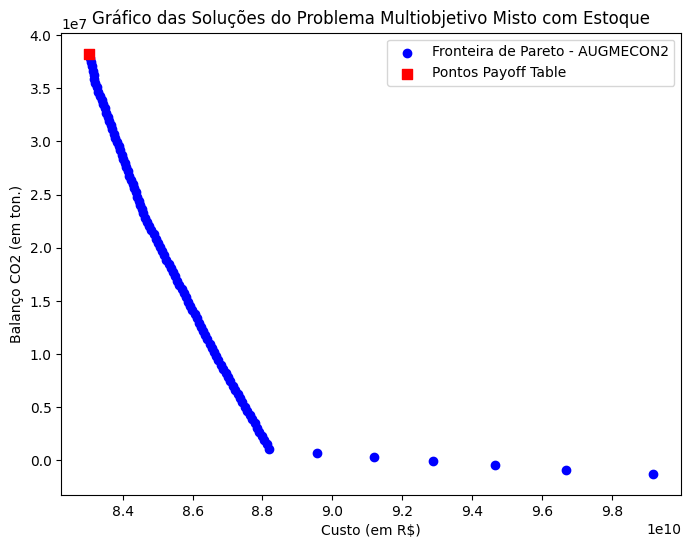

In [85]:
# Adicionando os pontos da payoff table
payoff_f1 = pf.iloc[:,0][0]#.values.tolist()  # Valores da função custo
payoff_f2 = pf.iloc[:,1][0]#.values.tolist()  # Valores da função CO2

# Criando o gráfico
plt.figure(figsize=(8, 6))

# Plotando todos os pontos da otimização em azul
plt.scatter(valores_f1, valores_f2, color='blue', label='Fronteira de Pareto - AUGMECON2')

# Plotando os pontos da payoff table em vermelho
plt.scatter(payoff_f1, payoff_f2, color='red', label='Pontos Payoff Table', marker='s', s=50)

# Configuração dos eixos
plt.xlabel('Custo (em R$)')
plt.ylabel('Balanço CO2 (em ton.)')
plt.title('Gráfico das Soluções do Problema Multiobjetivo Misto com Estoque')

# Adicionando a legenda
plt.legend()

# Exibindo o gráfico
plt.show()

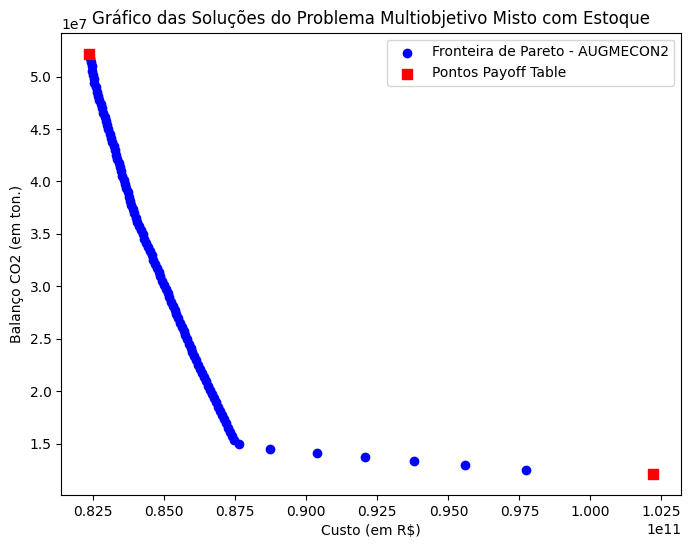

In [57]:
# Adicionando os pontos da payoff table
payoff_f1 = pf.iloc[:,0].values.tolist()  # Valores da função custo
payoff_f2 = pf.iloc[:,1].values.tolist()  # Valores da função CO2

# Criando o gráfico
plt.figure(figsize=(8, 6))

# Plotando todos os pontos da otimização em azul
plt.scatter(valores_f1, valores_f2, color='blue', label='Fronteira de Pareto - AUGMECON2')

# Plotando os pontos da payoff table em vermelho
plt.scatter(payoff_f1, payoff_f2, color='red', label='Pontos Payoff Table', marker='s', s=50)

# Configuração dos eixos
plt.xlabel('Custo (em R$)')
plt.ylabel('Balanço CO2 (em ton.)')
plt.title('Gráfico das Soluções do Problema Multiobjetivo Misto com Estoque')

# Adicionando a legenda
plt.legend()

# Exibindo o gráfico
plt.show()

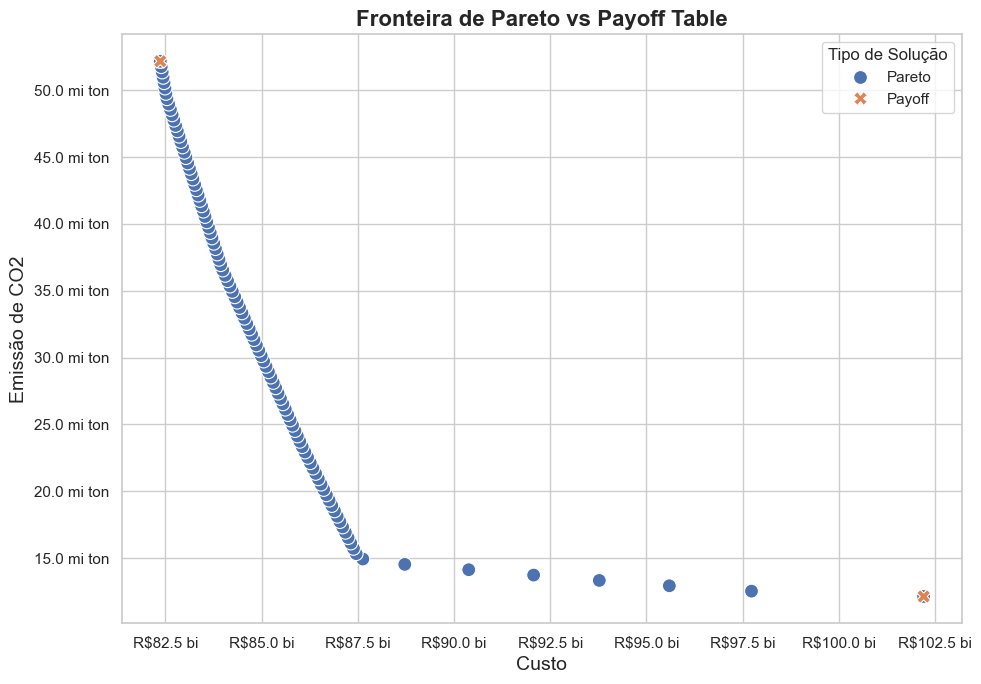

In [58]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Preparando os dados
df = pd.DataFrame({
    'Custo': valores_f1 + payoff_f1,
    'CO2': valores_f2 + payoff_f2,
    'Grupo': ['Pareto'] * len(valores_f1) + ['Payoff'] * len(payoff_f1)
})

# Formatadores
def formatar_em_bilhoes(x, _):
    return f'R${x/1e9:.1f} bi'

def formatar_em_milhoes(x, _):
    return f'{x/1e6:.1f} mi ton'

# Estilo
sns.set(style='whitegrid')

# Gráfico
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Custo', y='CO2', hue='Grupo', style='Grupo', s=100)

# Aplicando formatadores aos eixos
plt.gca().xaxis.set_major_formatter(FuncFormatter(formatar_em_bilhoes))
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_em_milhoes))

# Título e eixos
plt.title('Fronteira de Pareto vs Payoff Table', fontsize=16, fontweight='bold')
plt.xlabel('Custo', fontsize=14)
plt.ylabel('Emissão de CO2', fontsize=14)
plt.legend(title='Tipo de Solução')
plt.tight_layout()
plt.show()


In [238]:
df_porto_mercado.head()

,Porto,Mercado Externo,Distância (km),Custo de Exportação por ton.,Custo de Transporte (RS/ton/km),Taxa de Emissão ( ton CO2 /ton.*km),Demanda,Periodo,Variaveis Decisão Transporte Porto-Mercado_Externo,Variaveis Decisão Estoque Porto
0,"Santos, São Paulo",China - Xangai,18651.14,980,0.0100,0.00006,916868.5,1,"PME_Santos,_São_Paulo_China___Xangai_P1","I_porto_Santos,_São_Paulo_P1"
1,"Santos, São Paulo",China - Xangai,18651.14,980,0.0100,0.00006,916868.5,2,"PME_Santos,_São_Paulo_China___Xangai_P2","I_porto_Santos,_São_Paulo_P2"
2,São Francisco do Sul,China - Xangai,18983.97,320,0.0002,0.00050,916868.5,1,PME_São_Francisco_do_Sul_China___Xangai_P1,I_porto_São_Francisco_do_Sul_P1
3,São Francisco do Sul,China - Xangai,18983.97,320,0.0002,0.00050,916868.5,2,PME_São_Francisco_do_Sul_China___Xangai_P2,I_porto_São_Francisco_do_Sul_P2
4,"Vitória, Espírito Santo",China - Xangai,17909.67,410,0.0003,0.00030,916868.5,1,"PME_Vitória,_Espírito_Santo_China___Xangai_P1","I_porto_Vitória,_Espírito_Santo_P1"


In [153]:
def payoff_table2_expandida():
    eps = 1e-5  # equivalente a 10e-6
    iteracoes_desejadas = [6, 3]

    # Objetivos puros
    funcoes = [
        funcao_custo(df_2, df_demanda, df_frete, df_1, df_estoque, df_portos, df_porto_mercado,df_ativacao_silo),
        funcao_co2(df_1, df_demanda, df_2, df_portos, df_porto_mercado)
    ]

    nomes_funcoes = ["Minimizar Função Custo", "Minimizar Função CO2"]
    nomes_completos = nomes_funcoes + [f"Iteração {i}" for i in iteracoes_desejadas]
    colunas_payoff = ["Valor Função Custo", "Valor Função CO2"]
    payoff_matrix = pd.DataFrame(columns=colunas_payoff, index=nomes_completos)

    # Armazenar variáveis de decisão
    variaveis_otimizacao = {}

    # Primeira parte: otimização dos objetivos puros
    for i, funcao in enumerate(funcoes):
        problem = LpProblem("Problema_Otimização", LpMinimize)
        problem = restricoes2(problem)
        problem += funcao
        problem.solve()

        # Armazena os valores das funções objetivo
        payoff_matrix.iloc[i, 0] = value(funcoes[0])
        payoff_matrix.iloc[i, 1] = value(funcoes[1])

        # Armazena variáveis de decisão
        nome = "Min_Custo" if i == 0 else "Min_CO2"
        variaveis_otimizacao[nome] = {var.name: var.varValue for var in problem.variables()}

    # Segunda parte: soluções das iterações específicas
    for iteracao in iteracoes_desejadas:
        problem = LpProblem(f"Multiobjetivo_Iter_{iteracao}", LpMinimize)
        problem, s2_val, f1_val, f2_val = problema_multi_objetivo(problem, iteracao, eps)

        nome_linha = f"Iteração {iteracao}"
        payoff_matrix.loc[nome_linha] = [f1_val, f2_val]
        variaveis_otimizacao[nome_linha] = {var.name: var.varValue for var in problem.variables()}

    # Exporta DataFrames de variáveis de decisão para cada solução
    for nome, vars_dict in variaveis_otimizacao.items():
        df_vars = pd.DataFrame(list(vars_dict.items()), columns=["Variável", "Valor"])
        df_vars.to_excel(f"variaveis_{nome}.xlsx", index=False, sheet_name=nome)

    # Exporta tabela final da payoff
    payoff_matrix.to_excel("payoff_table_expandida.xlsx", index=True)

    return payoff_matrix


In [155]:
a=payoff_table2_expandida()